# Estimating the effective reproduction number in Belgium with the RKI method
> Using the Robert Koch Institute method with serial interval of 4.

- toc:true
- branch: master
- badges: true
- comments: true
- author: Lode Nachtergaele
- categories: [cast42, covid19, Belgium]

Every day [Bart Mesuere](https://twitter.com/BartMesuere) tweets a nice dashboard with current numbers about Covid-19 in Belgium. This was the tweet on Wednesday 20/11/04:
  
  > twitter: https://twitter.com/BartMesuere/status/1323881489864548352


It's nice to see that the effective reproduction number ($Re(t)$) is again below one. That means the power of virus is declining and the number of infection will start to lower. This occured first on Tuesday 2020/11/3:

   > twitter: https://twitter.com/BartMesuere/status/1323519613855059968
   

I estimated the $Re(t)$ earlier with [rt.live](https://github.com/rtcovidlive/covid-model) model in [this notebook](https://cast42.github.io/blog/cast42/covid19/belgium/2020/11/01/rt-be-region.html). There the $Re(t)$ was still estimated to be above one. [Michael Osthege](https://twitter.com/theCake) replied with a simulation results with furter improved [model](https://github.com/rtcovidlive/rtlive-global):

   > twitter: https://twitter.com/theCake/status/1323211910481874944

   

In that estimation, the $Re(t)$ was also not yet heading below one at the end of october.

In this notebook, we will implement a calculation based on the method of the Robert Koch Institute. The method is described and programmed in R in this [blog post](https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html).

In that blogpost there's a link to a website with estimations for most places in the world [The estimation for Belgium is here](https://epiforecasts.io/covid/posts/national/belgium/)

![LSHTM](images/LSHTM.png)

According to that calculation, $Re(t)$ is already below zero for some days.

# Load libraries and data

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_tests = pd.read_csv('https://epistat.sciensano.be/Data/COVID19BE_tests.csv', parse_dates=['DATE'])

In [3]:
df_cases = pd.read_csv('https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.csv', parse_dates=['DATE'])
df_cases

,DATE,PROVINCE,REGION,AGEGROUP,SEX,CASES
0,2020-03-01,Antwerpen,Flanders,40-49,M,1
1,2020-03-01,Brussels,Brussels,10-19,F,1
2,2020-03-01,Brussels,Brussels,10-19,M,1
3,2020-03-01,Brussels,Brussels,20-29,M,1
4,2020-03-01,Brussels,Brussels,30-39,F,1
...,...,...,...,...,...,...
36023,NaT,VlaamsBrabant,Flanders,40-49,M,3
36024,NaT,VlaamsBrabant,Flanders,50-59,M,1
36025,NaT,WestVlaanderen,Flanders,20-29,F,1
36026,NaT,WestVlaanderen,Flanders,50-59,M,3


Reformat data into Rtlive format

In [4]:
df_cases_per_day = (df_cases
   .dropna(subset=['DATE'])
   .assign(region='Belgium')
   .groupby(['region', 'DATE'], as_index=False)
   .agg(cases=('CASES', 'sum'))
   .rename(columns={'DATE':'date'})
   .set_index(["region", "date"])
)

What's in our basetable:

In [5]:
df_cases_per_day

cases
region  date             
Belgium 2020-03-01     19
        2020-03-02     19
        2020-03-03     34
        2020-03-04     53
        2020-03-05     81
...                   ...
        2020-10-31   6178
        2020-11-01   2601
        2020-11-02  12577
        2020-11-03   5165
        2020-11-04      9

[249 rows x 1 columns]

Let's plot the number of cases in function of the time.

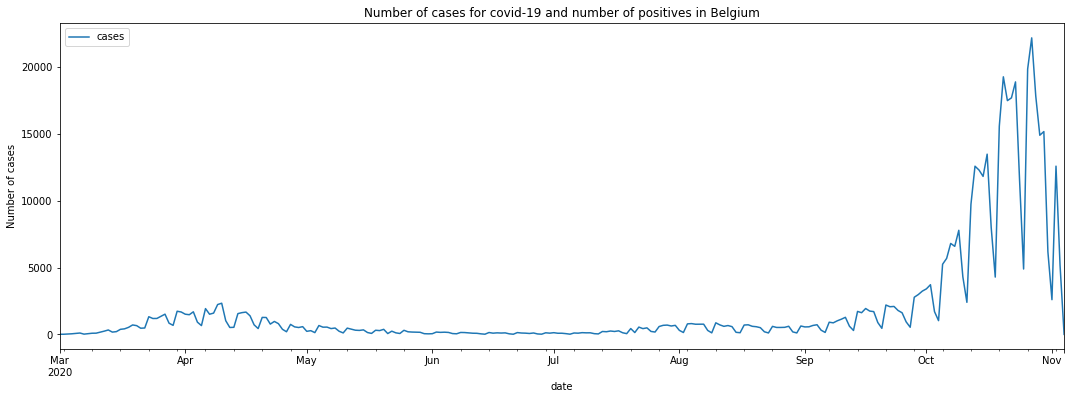

In [6]:
ax = df_cases_per_day.loc['Belgium'].plot(figsize=(18,6))
ax.set(ylabel='Number of cases', title='Number of cases for covid-19 and number of positives in Belgium');

We see that the last days are not yet complete. Let's cut off the last two days of reporting.

In [7]:
import datetime
from dateutil.relativedelta import relativedelta

Calculate the date two days ago:

In [8]:

today_minus_two = datetime.datetime.today() + relativedelta(days=-2)
today_minus_two.strftime("%Y-%m-%d")

'2020-11-03'

Replot the cases:

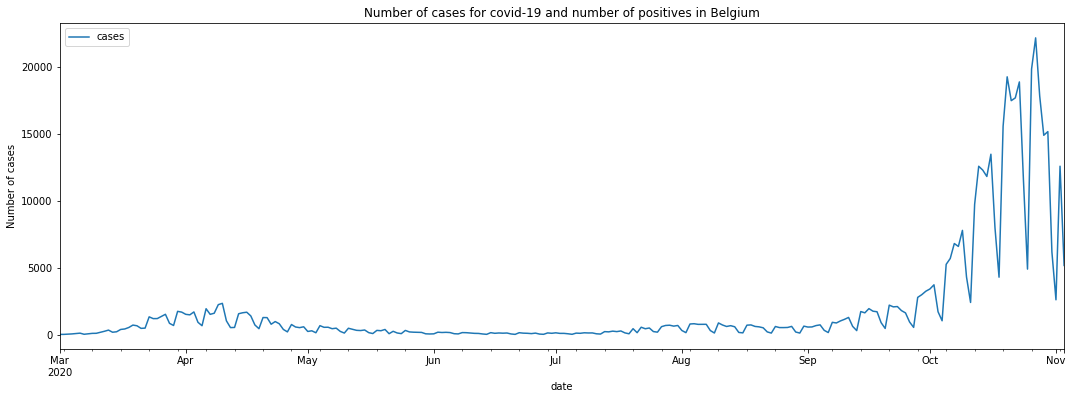

In [9]:
ax = df_cases_per_day.loc['Belgium'][:today_minus_two].plot(figsize=(18,6))
ax.set(ylabel='Number of cases', title='Number of cases for covid-19 and number of positives in Belgium');

Select the Belgium region:

In [10]:
region = 'Belgium'
df = df_cases_per_day.loc[region][:today_minus_two]
df

,cases
date,
2020-03-01,19
2020-03-02,19
2020-03-03,34
2020-03-04,53
2020-03-05,81
...,...
2020-10-30,15161
2020-10-31,6178
2020-11-01,2601


Check the types of the columns:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2020-03-01 to 2020-11-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   248 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


# Robert Koch Institute method

A basic method to calculate the effective reproduction number is described (among others) in this [blogpost](https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html). I included the relevant paragraph:

In a recent report (an der Heiden and Hamouda 2020) the RKI described their method for computing R as part of the COVID-19 outbreak as follows (p. 13): For a constant generation time of 4 days, one obtains R
 as the ratio of new infections in two consecutive time periods each consisting of 4 days. Mathematically, this estimation could be formulated as part of a statistical model:

$$y_{s+4} | y_{s} \sim Po(R \cdot y_{s}), s= 1,2,3,4$$

where $y_{1}, \ldots, y_{4}$ are considered as fixed. From this we obtain 

$$\hat{R}_{RKI} = \sum_{s=1}^{4} y_{s+4} / \sum_{s=1}^{4} y_{s}$$

Somewhat arbitrary, we denote by $Re(t)$ the above estimate for 
R when $s=1$ corresponds to time $t-8$, i.e. we assign the obtained value to the last of the 8 values used in the computation.

In Python, we define a lambda function that we apply on a rolling window. Since indexes start from zero, we calculate:

$$\hat{R}_{RKI} = \sum_{s=0}^{3} y_{s+4} / \sum_{s=0}^{3} y_{s}$$

In [12]:
rt = lambda y: np.sum(y[3:])/np.sum(y[:3])

In [13]:
df.rolling(8).apply(rt)

,cases
date,
2020-03-01,NaN
2020-03-02,NaN
2020-03-03,NaN
2020-03-04,NaN
2020-03-05,NaN
...,...
2020-10-30,2.544469
2020-10-31,2.100609
2020-11-01,1.208181


The first values are Nan because the window is in the past. If we plot the result, it looks like this:

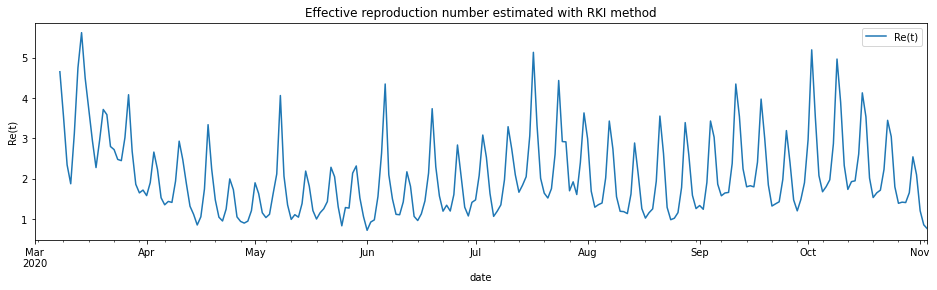

In [14]:
ax = df.rolling(8).apply(rt).plot(figsize=(16,4), label='Re(t)')
ax.set(ylabel='Re(t)', title='Effective reproduction number estimated with RKI method')
ax.legend(['Re(t)']);

To avoid the spikes due to weekend reporting issue, I first applied a rolling mean on a window of 7 days:

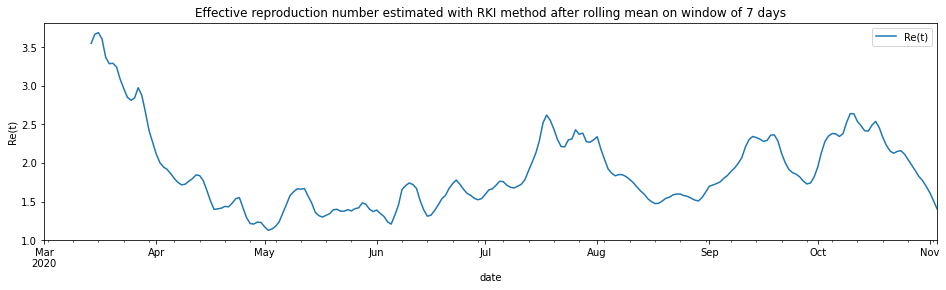

In [15]:
ax = df.rolling(7).mean().rolling(8).apply(rt).plot(figsize=(16,4), label='Re(t)')
ax.set(ylabel='Re(t)', title='Effective reproduction number estimated with RKI method after rolling mean on window of 7 days')
ax.legend(['Re(t)']);

# Interactive visualisation in Altair

In [16]:
import altair as alt

alt.Chart(df.rolling(7).mean().rolling(8).apply(rt).fillna(0).reset_index()).mark_line().encode(
    x=alt.X('date:T'),
    y=alt.Y('cases', title='Re(t)'),
    tooltip=['date:T', alt.Tooltip('cases', format='.2f')]
).transform_filter(
    alt.datum.date > alt.expr.toDate('2020-03-13')
).properties(
    width=600,
    title='Effective reproduction number in Belgium based on Robert-Koch Institute method'
)

alt.Chart(...)

# Making the final visualisation in Altair

In the interactive Altair figure below, we show the $Re(t)$ for the last 14 days. We reduce the rolling mean window to three to see faster reactions.

In [17]:
#collapse

df_plot = df.rolling(3).mean().rolling(8).apply(rt).fillna(0).reset_index()
last_value = str(df_plot.iloc[-1]['cases'].round(2)) + ' ↓'
first_value = str(df_plot[df_plot['date'] == '2020-10-21'].iloc[0]['cases'].round(2)) # + ' ↑'
today_minus_15 = datetime.datetime.today() + relativedelta(days=-15)
today_minus_15_str = today_minus_15.strftime("%Y-%m-%d")

line = alt.Chart(df_plot).mark_line(point=True).encode(
    x=alt.X('date:T', axis=alt.Axis(title='Datum', grid=False)),
    y=alt.Y('cases', axis=alt.Axis(title='Re(t)', grid=False, labels=False, titlePadding=40)),
    tooltip=['date:T', alt.Tooltip('cases', title='Re(t)', format='.2f')]
).transform_filter(
    alt.datum.date > alt.expr.toDate(today_minus_15_str)
).properties(
    width=600,
    height=100
)

hline = alt.Chart(pd.DataFrame({'cases': [1]})).mark_rule().encode(y='cases')


label_right = alt.Chart(df_plot).mark_text(
    align='left', dx=5, dy=16+4 , size=15
).encode(
    x=alt.X('max(date):T', title=None),
    text=alt.value(last_value),
)

label_left = alt.Chart(df_plot).mark_text(
    align='right', dx=-5, dy=-17, size=15
).encode(
    x=alt.X('min(date):T', title=None),
    text=alt.value(first_value),
).transform_filter(
    alt.datum.date > alt.expr.toDate(today_minus_15_str)
)

source = alt.Chart(
    {"values": [{"text": "Data source: Sciensano"}]}
).mark_text(size=12, align='left', dx=-57).encode(
    text="text:N"
)

alt.vconcat(line + label_left + label_right + hline, source).configure(
    background='#D9E9F0'
).configure_view(
    stroke=None, # Remove box around graph
).configure_axisY(
    ticks=False,
    grid=False,
    domain=False
).configure_axisX(
    grid=False,
    domain=False
).properties(title={
      "text": ['Effective reproduction number for the last 14 days in Belgium'], 
      "subtitle": [f'Estimation based on the number of cases until {today_minus_two.strftime("%Y-%m-%d")} after example of Robert Koch Institute with serial interval of 4'],
}
)
# .configure_axisY(
#     labelPadding=50,
# )

alt.VConcatChart(...)